In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import ConnectionPatch
import numpy as np
import os
import cv2
from data_utils.utils import load_ann, keypoints_to_xy, paths

plt.rcParams['font.size'] = '18'

In [2]:
val_dataset_path = paths["val_img"]
val_ann_path = paths["val_ann"]

output_path = "data/output/visualization"

oks_sigmas = np.array([.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0
kapa = 2*oks_sigmas

c0 = [0.976, 0.255, 0.267, 1.0]
c1 = [0.973, 0.608, 0.118, 1.0]
c2 = [0.976, 0.780, 0.310, 1.0]
c3 = [0.263, 0.667, 0.545, 1.0]
c4 = [0.153, 0.490, 0.631, 1.0]

colors = [c0, c0, c0, c0, c0, c1, c1, c2, c2, c2, c2, c3, c3, c4, c4, c4, c4]

px_to_in = 0.0104166667

In [3]:
def load(iid):
    name = '%012d.jpg' % iid
    img_path = os.path.join(val_dataset_path, name)
    return cv2.imread(img_path)[:,:,::-1]


val_ann = load_ann(val_ann_path)

aid_to_ann = {}
iid_to_ann = {}

for a in val_ann['images']:
    iid_to_ann[a['id']] = []
for a in val_ann['annotations']:
    aid_to_ann[a['id']] = a
    iid_to_ann[a['image_id']].append(a)

In [4]:
def oks_r(oks, area, i):
    k = kapa[i]
    s2 = area
    r2 = (-np.log(oks) * s2 * k**2)
    r = np.sqrt(r2)
    return r

def oks(area, i, gt, r):
    k2 = kapa[i]**2
    s2 = area
    oks = np.exp(-(np.linalg.norm(gt-(gt+r))**2)/(2*s2*k2))
    return oks

def oks_gauss(area, i, gt):
    start = oks_r(0.99, area, i)*1.5
    end = oks_r(0.01, area, i)*1.5

    T = np.linspace(start-end, end, num=100)
    oks_g = []
    for t in T:
        outr = oks(area, i, gt, t)
        oks_g.append(outr)
    return  T + gt[0] , oks_g

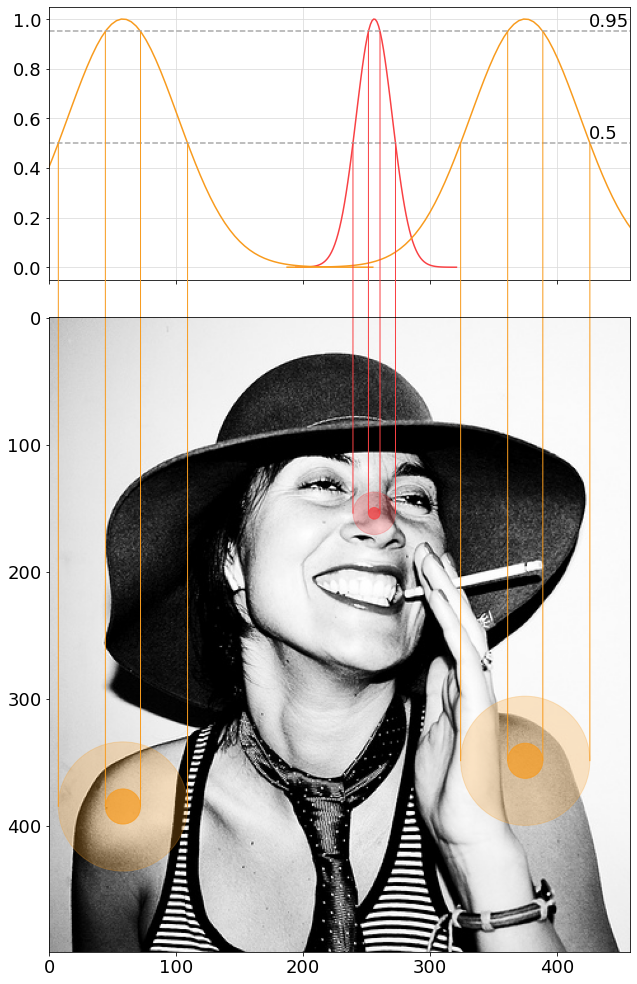

In [5]:
iid = 19924
oksv = [0.5, 0.95]
gauss_kp = [0, 5, 6]

img = load(iid)
ann = iid_to_ann[iid][0]
w, h, _ = img.shape

fig, ax = plt.subplots(2,1, figsize=(w*px_to_in*2, ((h*px_to_in)/3 * 6 ) * 2), gridspec_kw={'height_ratios': [1, 3]}, sharex=True, constrained_layout=False,)

xy = keypoints_to_xy(ann['keypoints'])
v = ann['keypoints'][2::3]

for k, j in enumerate(xy):
    if v[k] > 0:
        if k in gauss_kp:
            T, oks_g = oks_gauss(ann['area'], k, (j[0], j[1]))
            ax[0].plot(T, oks_g, color=colors[k])

            for oks_value in oksv:
                r = oks_r(oks_value, ann['area'], k)
                ax[1].add_patch( Circle((j[0], j[1]),
                                     color = colors[k],
                                     radius = r, alpha=oks_value-0.25) )
                con1 = ConnectionPatch(xyA=[j[0]-r, j[1]], xyB=[j[0]-r,oks_value], coordsA="data", coordsB="data", axesA=ax[1], axesB=ax[0], color=colors[k])
                con2 = ConnectionPatch(xyA=[j[0]+r, j[1]], xyB=[j[0]+r,oks_value], coordsA="data", coordsB="data", axesA=ax[1], axesB=ax[0], color=colors[k])
                ax[1].add_artist(con1)
                ax[1].add_artist(con2)

for o in oksv:
    ax[0].plot([0, w], [o, o], '--', color="darkgray")
    ax[0].annotate(str(o), xy=(w-75, o+0.02), xytext=(w-75, o+0.02), color='black')

ax[0].grid(color="gainsboro")
ax[1].imshow(img)

plt.subplots_adjust(hspace=-0.1)

fig.savefig(os.path.join(output_path, 'oks_gauss.pdf'), bbox_inches='tight')

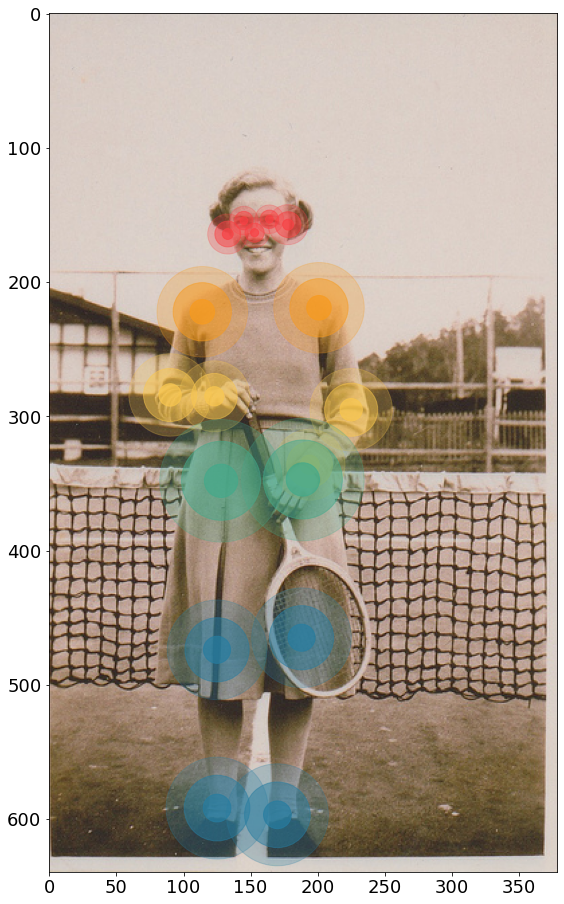

In [6]:
aid = 490929
oksv = [0.5, 0.75, 0.95]

iid2 = aid_to_ann[aid]['image_id']
img = load(iid2)
ann = aid_to_ann[aid]
w, h, _ = img.shape

fig, ax = plt.subplots(1,1, figsize=(w*px_to_in*4, h*px_to_in*4))

xy = keypoints_to_xy(ann['keypoints'])
v = ann['keypoints'][2::3]

for k, j in enumerate(xy):
    if v[k] > 0:
        for oks_value in oksv:
            r = oks_r(oks_value, ann['area'], k)
            ax.add_patch( Circle((j[0], j[1]),
                                       color = colors[k],
                                       radius = r, alpha=oks_value-0.25) )

ax.imshow(img)
fig.savefig(os.path.join(output_path, 'oks_full.pdf'), bbox_inches='tight')